In [1]:
'''
## Overview
This notebook uses the networks from 
12_2I1R_zebrafish_network_bincrease.ipynb but makes the density of
preferred HDs unequal across orientation, to approximately mimic the
real distribution found in zebrafish. 


## Author
Siyuan Mei (mei@bio.lmu.de)


## Last update
2025-9-14
'''
%load_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import ParameterGrid
from scipy.integrate import solve_ivp
from matplotlib import colors
from scipy.signal import find_peaks
from scipy.stats import pearsonr
import pandas as pd

import HD_utils.circular_stats as cstat
from HD_utils.network import *
from HD_utils.matrix import *
from HD_utils.adap_sim_move import *
from HD_utils.adap_sim_stable import *
from HD_utils.IO import *
from HD_utils.plot import *
from HD_utils.comput_property import *
from HD_utils.exam import *
from HD_utils.network import *
import HD_utils.unequalHD as ueHD

# Parameters Set Up

In [2]:
# Simulation theta precision
theta_num = 50

dtheta_sym = (2*np.pi)/theta_num
theta_range_sym = np.arange(-np.pi+dtheta_sym/2, np.pi, dtheta_sym)

dtheta = np.repeat(dtheta_sym, theta_num)
theta_range = [theta_range_sym]

shifts = [-np.pi/2, np.pi/2]
for shift in shifts:
    dthetai, theta_rangei = ueHD.asy_theta_range(theta_range_sym, shift)
    dtheta = np.concatenate((dtheta, dthetai))
    theta_range.append(theta_rangei) # in the order: center, left, right

# Changeable parameters
ring_num = 3
actfun = max0x
weight_fun = vonmises_weight_2i1r_unequal_theta
search_pars = {'JI': np.linspace(-50,0,6), 'JE': np.linspace(0,50,6), 'K0': np.linspace(-50,0,6), 'kappa': np.logspace(-0.2,1,6)}
file_pre_name = 'new_15_1_copy'
# Default parameters
inputs = np.array([-1, -0.6, -0.3, -0.1, 0, 0.1, 0.3, 0.6, 1])
net_diff_equa = net_diff_equa_f_in
phi = -np.pi * 8/9
tau = 20 # ms
b0 = 1
bc = 1
# Generated parameters
par_num = len(search_pars)
search_num = len(ParameterGrid(search_pars))
zeroid = np.where(inputs == 0)[0][0]
par_names = list(search_pars.keys())
input_num = len(inputs)

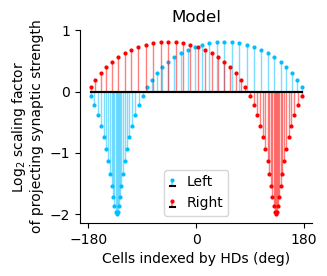

In [3]:
theta_num = 50
dtheta_sym = (2*np.pi) / theta_num
theta_range_sym = np.arange(-np.pi+dtheta_sym/2, np.pi, dtheta_sym)


fig, ax = plt.subplots(figsize=(3,2.5))
ax.set_title('Model')

colors = ['deepskyblue', 'red']
labels = ['Left', 'Right']
for i in range(2):
    dtheta_temp, theta_rangei = ueHD.asy_theta_range(theta_range_sym, shifts[i])
    markerline, stemlines, baseline = ax.stem(theta_rangei/np.pi*180, np.log2(dtheta_temp/dtheta_sym), label=labels[i])

    plt.setp(stemlines, 'linewidth', 1)  # stem width
    stemlines.set_color(colors[i])
    stemlines.set_alpha(0.5)
    
    plt.setp(markerline, 'markersize', 2)  # dot size
    markerline.set_color(colors[i])
    
    baseline.set_color('black')

ax.legend(handlelength=0.4)

for pos in ['top', 'right']:
    ax.spines[pos].set_visible(False)
    
ax.set_ylabel('Log$_2$ scaling factor\nof projecting synaptic strength')
ax.set_yticks([-2,-1,0,1])

ax.set_xticks([-180,0,180])
ax.set_xlabel('Cells indexed by HDs (deg)')

plt.show()

# Load Data

In [4]:
# Run it after the simulation in the current notebook has been saved

# network_evals, network_evaldes, network_acvs, network_pars, network_ts = load_pickle(
#     ['evals', 'eval_des', 'acvs', 'pars', 'ts'], weight_fun, actfun, file_pre_name)
# valid_index_s = np.where(network_evals == 'valid')[0]
# valids_num = len(valid_index_s)

# Vels, network_eval_moving, network_eval_moving_des, network_acvs_moving, network_ts_moving, network_eval_moving_sum = load_pickle(
#     ['moving_slope', 'moving_eval', 'moving_eval_des', 'moving_acvs', 'moving_ts', 'moving_eval_sum'], weight_fun, actfun, file_pre_name)

# stable_mov_range, stable_mov_range_id, linear_mov_range, linear_mov_range_id = \
#     cal_linear_range(network_eval_moving, Vels, inputs, valid_index_s)
# valid_index_linear_move = np.where(np.diff(linear_mov_range_id, axis=1) == 8)[0]

# Stable

In [5]:
# ---- Need Change
t_max1 = tau * 10 # value must be bigger than 200, if t > t_max1 & network has a bad shape, end simulation
t_max2 = tau * 50 # if t > t_max2, stop simulation, even though network has a good shape
# Routine
network_acvs = np.zeros(search_num, dtype='object')
network_evals= np.ones(search_num, dtype='U30')
network_evaldes = np.zeros(search_num, dtype='object')
network_pars = np.zeros((search_num, par_num))
network_ts = np.zeros(search_num, dtype='object')

for i, pars in enumerate(tqdm(  list(ParameterGrid(search_pars))  )):
    # --- Need change
    par_list = [pars[par_names[j]] for j in range(par_num)]
    w = weight_fun(*par_list, phi, theta_num, theta_range, dtheta)
    ## Routine
    b = steady_inputb_2rr(bc, b0, 0, theta_num)# . actually, bC is not used.
    s0 = net_ini_v3(theta_range, ring_num=3)
    y, t, network_evals[i], network_evaldes[i] = \
        inte_check_sta(net_diff_equa, t_max1, t_max2, s0, w, tau, b, theta_num, actfun)
    # Store values
    network_pars[i] = par_list
    network_acvs[i] = np.array([y[:theta_num], y[theta_num:2*theta_num], y[2*theta_num:]]) # Order of rings: readout, left, right
    network_ts[i] = t
# save simulation result
store_pickle([network_evals, network_evaldes, network_acvs, network_pars, network_ts], 
['evals', 'eval_des', 'acvs', 'pars', 'ts'], weight_fun, actfun, file_pre_name)

valid_index_s = np.where(network_evals == 'valid')[0]
valids_num = len(valid_index_s)
print(valids_num)

100%|██████████| 1296/1296 [00:21<00:00, 61.13it/s]

332


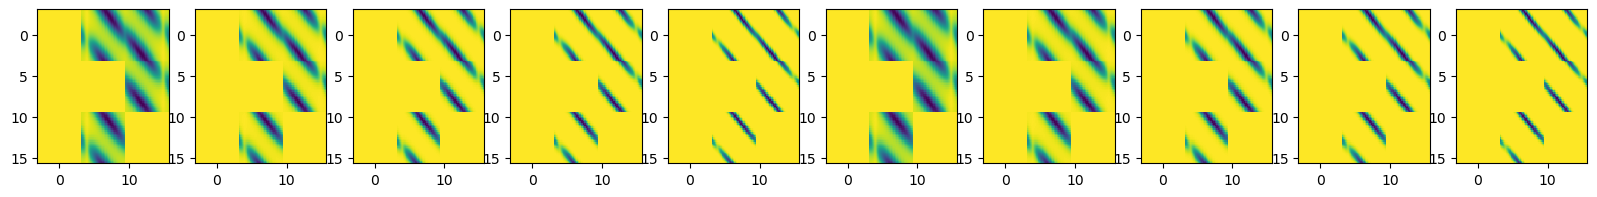

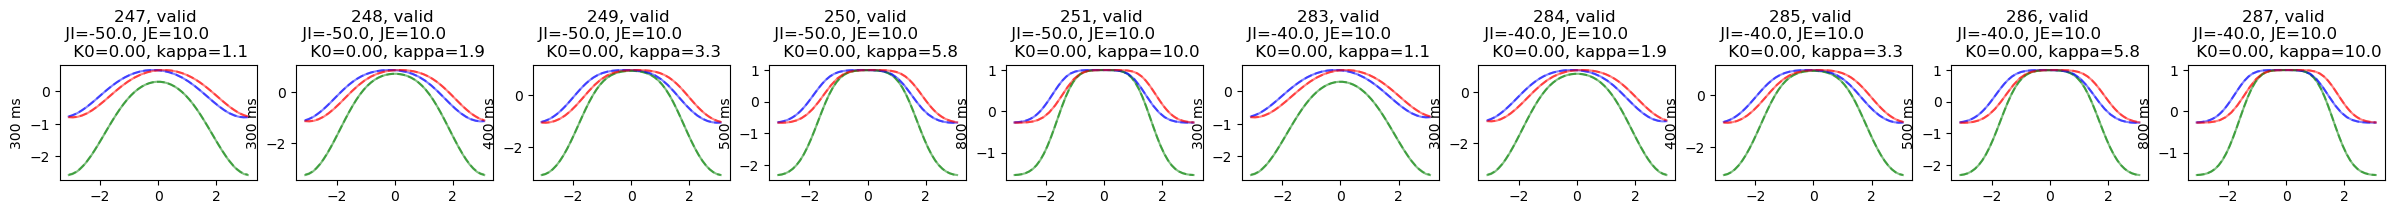

In [6]:
theta_range_coor = np.concatenate([theta_range[0], theta_range[1]+np.pi*2, theta_range[2]+np.pi*4])
index_vis = np.where( (network_evals == 'valid')  )[0][::1][:10]
# index_vis = valid_index_linear_move[::1]
total_subplots = len(index_vis)
subplot_per_row = 10
for i in range(int(np.ceil(total_subplots/subplot_per_row))):
    fig, axs = plt.subplots(1, subplot_per_row,  figsize=(2*subplot_per_row ,2))
    for j in range(subplot_per_row):
        try:
            pars = network_pars[index_vis[i*subplot_per_row + j]]
        except:
            break
        w = weight_fun(*pars, phi, theta_num, theta_range, dtheta)
        ax = axs[j]
        X, Y = np.meshgrid(theta_range_coor, theta_range_coor)
        ax.invert_yaxis()
        im = ax.pcolormesh(X,Y,w)
    plt.show()
    sample_stable_shape_3r_unequal_theta(index_vis[i*subplot_per_row:(i+1)*subplot_per_row], network_evals, network_pars, network_acvs, network_ts, par_names, theta_range, fig_per_row=subplot_per_row, times=1, maxnum=20)

# Moving

In [7]:
# Initialize store variables
network_eval_moving = np.zeros(( search_num, len(inputs) ), dtype='U30')
network_eval_moving_sum = np.copy(network_evals)
network_vvcor = np.zeros((search_num, ring_num, 2))
network_acvs_moving = np.zeros((search_num, len(inputs)), dtype='object')
network_ts_moving = np.zeros((search_num, len(inputs)), dtype='object')
Vels = np.zeros((search_num, len(inputs), ring_num)) 

for i in tqdm(valid_index_s):
    # parameters and weight ---- Need Change
    w = weight_fun(*network_pars[i], phi, theta_num, theta_range, dtheta)
    # Routine
    s1 = np.concatenate( [network_acvs[i][0,:,-1], network_acvs[i][1,:,-1], network_acvs[i][2,:,-1]] ) # Initial state is the stable state in the stationary case
    for ratioi, ratiov in enumerate(inputs):
        b = steady_inputb_2rr_b_increase(bc, b0, ratiov, theta_num)
        ## Compute network dynamics 
        y, t, network_eval_moving[i,ratioi], Vels[i,ratioi] = inte_check_move(
            net_diff_equa, s1, w, tau, b, theta_num, actfun, theta_range=theta_range)
        ## Store values
        network_acvs_moving[i,ratioi] = np.array([y[:theta_num], y[theta_num:2*theta_num], y[2*theta_num:]]) # Order of rings: readout, left, right
        network_ts_moving[i,ratioi] = t
    ## Examine
    network_eval_moving[i][zeroid] = 'stable moving'
    network_eval_moving_sum[i] = 'valid stationary shape'
    if np.all(network_eval_moving[i] == 'stable moving'):
        network_vvcor[i] = cal_correlation(inputs, Vels[i])
        network_eval_moving_sum[i] = exam_vv_linearity(network_vvcor[i])
## save simulation result
store_pickle([Vels, network_eval_moving, network_vvcor, network_acvs_moving, network_ts_moving, network_eval_moving_sum], 
             ['moving_slope', 'moving_eval', 'moving_eval_des', 'moving_acvs', 'moving_ts', 'moving_eval_sum'], 
             weight_fun, actfun, file_pre_name)

100%|██████████| 332/332 [00:45<00:00,  7.31it/s]


In [8]:
stable_mov_range, stable_mov_range_id, linear_mov_range, linear_mov_range_id = \
    cal_linear_range(network_eval_moving, Vels, inputs, valid_index_s)
valid_index_move = np.where(np.diff(stable_mov_range_id, axis=1) >= 2)[0]
valid_index_whole_move = np.where(np.diff(stable_mov_range_id, axis=1) == 8)[0]
valid_index_linear_move = np.where(np.diff(linear_mov_range_id, axis=1) == 8)[0]
df = pd.DataFrame([[len(valid_index_s), len(valid_index_move), len(valid_index_whole_move), len(valid_index_linear_move)]]\
                  , columns=['Stationary valid', 'Somehow moves', 'whole range moves', 'whole range linear'], index=[''])
display(df)

,Stationary valid,Somehow moves,whole range moves,whole range linear
,332,259,54,54
